## Evaluation of Geometric and Standard Methods

In [1]:
from ccaman.ccaman import CCAMan

ccaman = CCAMan()
ccaman.analyze()

Wrote to file


In [25]:
print(ccaman.genes_to_cellline)

                     AU565     HCC1143     HCC1395     HCC1419     HCC1428  \
EnsEMBL_Gene_ID                                                              
ENSG00000000003  13.460144  216.930143   96.785401    6.847876   43.965782   
ENSG00000001167  68.907655  285.900419  347.992398   98.756895  162.757442   
ENSG00000005471   2.976117    0.000000    0.054333    2.402739    2.713846   
ENSG00000066629  15.084108   16.952487   97.143133   34.884041   79.282346   
ENSG00000154258   0.000000    0.102304    0.207510    0.097948    0.000000   
...                    ...         ...         ...         ...         ...   
ENSG00000154229  51.196873   51.165867   80.279190    1.276649    1.676753   
ENSG00000154237   3.121563   38.674515    2.983126   33.744973    4.347457   
ENSG00000154240   0.222417   48.908626    2.149875    0.000000    0.689206   
ENSG00000154251   0.224694   40.042918   24.033986   82.585739   63.944153   
ENSG00000154252   3.185827    0.000000    0.000000  144.835135  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ccaman.sensitivity_data

,Cell Line,Drug Name,Z Score
0,AU565,Lapatinib,-2.583650
1,AU565,Alpelisib,-0.925285
2,AU565,Tamoxifen,-0.872274
3,AU565,Palbociclib,-0.147910
4,AU565,Olaparib,0.179425
...,...,...,...
71,T47D,Alpelisib,-1.311439
72,T47D,Tamoxifen,-1.245510
73,T47D,Lapatinib,-0.146497
74,T47D,Palbociclib,-0.131184


In [27]:
# Select the Z scores for the first medicament: Lapatinib
lapatinib = ccaman.sensitivity_data.loc[
    ccaman.sensitivity_data["Drug Name"] == "Lapatinib"
]
# Elininate the second column
lapatinib = lapatinib.drop(columns=["Drug Name"])
print(lapatinib)

   Cell Line   Z Score
0      AU565 -2.583650
5    HCC1143 -0.756084
11   HCC1395 -0.679557
15   HCC1419 -1.251459
20   HCC1428  0.298439
26   HCC1569 -0.774573
31   HCC1599 -0.383583
36  HCC18064 -0.863270
40   HCC1937 -0.380178
46   HCC1954 -0.930000
51   HCC2218 -2.656450
57     HCC38 -0.112642
61     HCC70 -0.142058
68      MCF7 -0.553821
73      T47D -0.146497


In [44]:
# Make our Y matrix for CCA be the Z scores for Lapatinib
Y = lapatinib.iloc[:, 1:]  # For CCA we only need the Z scores
Y.shape

(15, 1)

In [ ]:
X = ccaman.genes_to_cellline.T  # Shape becomes (15 cell lines x 36953 genes)

(1, 15)

In [45]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)  # Standardize gene expression
Y_scaled = scaler_Y.fit_transform(Y)  # Standardize Z-scores

In [47]:
cca = CCA(n_components=1)  # We only need the first component for analysis
cca.fit(X_scaled, Y_scaled)

X_c, Y_c = cca.transform(X_scaled, Y_scaled)  # Canonical components
correlation = np.corrcoef(X_c.T, Y_c.T)[0, 1]
print(f"Canonical Correlation: {correlation}")

Canonical Correlation: 0.9999999999999997


In [48]:
gene_weights = cca.x_weights_[:, 0]  # Weights of genes in the first component
important_genes = np.argsort(np.abs(gene_weights))[::-1][:10]  # Top 10 genes
print("Top contributing genes:", important_genes)

Top contributing genes: [34907 32344  3022  1685 27913 12846 10040 12189 30292 33101]


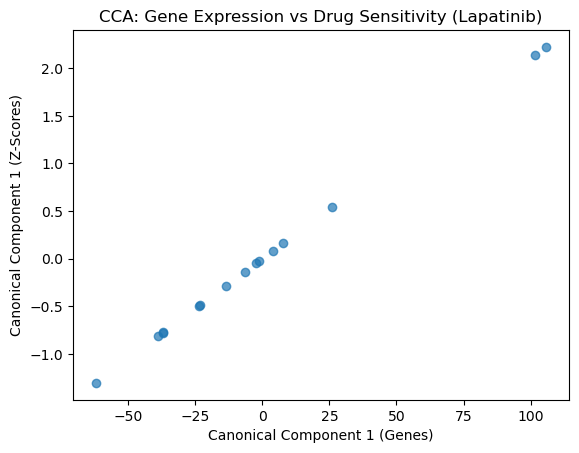

In [49]:
plt.scatter(X_c, Y_c, alpha=0.7)
plt.xlabel("Canonical Component 1 (Genes)")
plt.ylabel("Canonical Component 1 (Z-Scores)")
plt.title("CCA: Gene Expression vs Drug Sensitivity (Lapatinib)")
plt.show()

In [ ]:
# Pivot sensitivity data to have drugs as columns and cell lines as rows
sensitivity_pivot = ccaman.sensitivity_data.pivot(
    index="Cell Line", columns="Drug Name", values="Z Score"
)
sensitivity_pivot
# Align the gene expression data and drug sensitivity data by cell lines
gene_expression = (
    ccaman.genes_to_cellline.T
)  # transpose because the genes are in the rows
common_cell_lines = sensitivity_pivot.index.intersection(gene_expression.index)
sensitivity_pivot = sensitivity_pivot.loc[common_cell_lines]
gene_expression = gene_expression.loc[common_cell_lines]

# Normalize both datasets
scaler = StandardScaler()
X = scaler.fit_transform(gene_expression)  # Gene expression data
Y = scaler.fit_transform(sensitivity_pivot)  # Z Scores

In [4]:
gene_expression.head()

EnsEMBL_Gene_ID,ENSG00000000003,ENSG00000001167,ENSG00000005471,ENSG00000066629,ENSG00000154258,ENSG00000154262,ENSG00000154263,ENSG00000154265,ENSG00000154269,ENSG00000154274,...,ENSG00000154188,ENSG00000154198,ENSG00000154217,ENSG00000154222,ENSG00000154227,ENSG00000154229,ENSG00000154237,ENSG00000154240,ENSG00000154251,ENSG00000154252
AU565,13.460144,68.907655,2.976117,15.084108,0.000000,0.000000,0.079746,3.017549,0.217142,28.473352,...,1.526250,1.049567,19.559808,77.265886,0.000000,51.196873,3.121563,0.222417,0.224694,3.185827
HCC1143,216.930143,285.900419,0.000000,16.952487,0.102304,0.060849,0.101803,5.663746,0.204348,2.179692,...,0.000000,0.000000,76.110740,40.020894,0.000000,51.165867,38.674515,48.908626,40.042918,0.000000
HCC1395,96.785401,347.992398,0.054333,97.143133,0.207510,0.082464,0.274115,9.425963,0.069234,1.163765,...,83.129169,0.000000,89.520007,29.160701,0.410169,80.279190,2.983126,2.149875,24.033986,0.000000
HCC1419,6.847876,98.756895,2.402739,34.884041,0.097948,0.116005,1.160639,17.628333,16.991243,45.617551,...,0.000000,24.516809,48.953813,95.270912,2.324565,1.276649,33.744973,0.000000,82.585739,144.835135
HCC1428,43.965782,162.757442,2.713846,79.282346,0.000000,0.000000,0.041734,20.237258,0.676882,156.145039,...,0.122677,6.645991,480.362749,62.865207,0.063281,1.676753,4.347457,0.689206,63.944153,1.103798


In [3]:
# Print rows with Nan values for sensitivity data
nan_rows = np.isnan(Y).any(axis=1)
print("Rows with NaN values in sensitivity data")
print(sensitivity_pivot[nan_rows])

Rows with NaN values in sensitivity data
Drug Name  Alpelisib  Lapatinib  Olaparib  Palbociclib  Tamoxifen
HCC202           NaN        NaN       NaN     0.828654        NaN


In [6]:
# Check for NaNs in X and Y
print(f"Number of NaNs in X: {pd.DataFrame(X).isna().sum().sum()}")
print(f"Number of NaNs in Y: {pd.DataFrame(Y).isna().sum().sum()}")

# Substitute NaNs with 0 for 0 sensitivity
Y = np.nan_to_num(Y, nan=0)

Number of NaNs in X: 0
Number of NaNs in Y: 4


In [7]:
# Perform Canonical Correlation Analysis (CCA)
cca = CCA(n_components=5)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

# Calculate the canonical correlation coefficients
correlations = np.corrcoef(X_c.T, Y_c.T)[:2, 2:]

print(f"Correlations: {correlations}")

Correlations: [[ 1.18500009e-15  1.84084629e-16  7.79500493e-16  1.00000000e+00
   2.42596988e-17  7.31730247e-16 -4.51857140e-16  7.07722689e-16]
 [-4.09771835e-16 -1.96552720e-16 -5.40452097e-17  2.26249476e-16
   1.00000000e+00 -8.13575225e-16 -5.77491821e-16  6.12291163e-16]]


The result corresponds to the analysis for the whole 5 drugs. A different correlation is expected when isolating the data.

In [11]:
# TODO: Check if X or Y have very low variance - might reduce the meaningful correlations captured by CCA.
# TODO: A value of exactly 1.0 was expected - the first canonical component often represents the strongest possible correlation.

In [13]:
# Transform the datasets into canonical components
X_c, Y_c = cca.transform(X, Y)
n_components = min(X.shape[1], Y.shape[1])
# Compute canonical correlations
correlations = np.corrcoef(X_c.T, Y_c.T)[:n_components, n_components:]
print("Canonical Correlation Coefficients:", np.diag(correlations))

Canonical Correlation Coefficients: [1. 1. 1. 1. 1.]


In [ ]:
# If the sample size is smaller than the number of features in X or Y, the CCA will find relationships that perfectly fit the data?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

pca = PCA(n_components=min(X.shape[0] - 1, X.shape[1]))
X_reduced = pca.fit_transform(X_scaled)
# Y_reduced = pca.fit_transform(Y_scaled)

In [ ]:
from sklearn.model_selection import train_test_split

# To prevent overfitting, we split your dataset into training and testing sets and evaluate the correlations on the test set:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.3, random_state=42
)

# Fit CCA on the training data
cca.fit(X_train, Y_train)

# Evaluate on the test data
X_test_c, Y_test_c = cca.transform(X_test, Y_test)
test_correlations = np.corrcoef(X_test_c.T, Y_test_c.T)[
    : cca.n_components, cca.n_components :
]
print("Test Correlations:", np.diag(test_correlations))

In [17]:
print(ccaman.sensitivity_data.head())

  Cell Line    Drug Name   Z Score
0     AU565    Lapatinib -2.583650
1     AU565    Alpelisib -0.925285
2     AU565    Tamoxifen -0.872274
3     AU565  Palbociclib -0.147910
4     AU565     Olaparib  0.179425


In [18]:
print(ccaman.genes_to_cellline.head())

                     184A1      184B5       21MT1       21MT2        21NT  \
EnsEMBL_Gene_ID                                                             
ENSG00000000003  95.212548  95.698676   19.994674   65.686376   44.057746   
ENSG00000001167  89.512619  94.154375  245.433541  216.487072  286.092419   
ENSG00000005471   0.000000   0.172734    0.231762    0.099938    0.000000   
ENSG00000066629  24.701397   7.633869    5.842132    6.773438    5.149179   
ENSG00000154258   0.000000   2.683498    0.000000    0.031877    0.000000   

                       21PT      600MPE      AU565       BT474       BT483  \
EnsEMBL_Gene_ID                                                              
ENSG00000000003   34.317565  178.158832  13.460144   37.879666   69.092581   
ENSG00000001167  289.298295  125.193255  68.907655  167.815672  152.752421   
ENSG00000005471    0.000000    0.757785   2.976117    1.210384    1.670807   
ENSG00000066629    7.432176   29.604076  15.084108   30.669290  135.10

['AU565' 'HCC1143' 'HCC1395' 'HCC1419' 'HCC1428' 'HCC1569' 'HCC1599'
 'HCC18064' 'HCC1937' 'HCC1954' 'HCC202' 'HCC2218' 'HCC38' 'HCC70' 'MCF7'
 'T47D']
